# TABLE OF AGREEMENT

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from utils import *

plt.style.use('../style.mplstyle')
df = pd.read_csv("../latest.csv")

In [2]:
df = fix_data(df, drop_zeros=False)

In [3]:
readings = df['reading'].values

In [4]:
# count how many 0's in readings
zero_count = np.sum(readings == 0)
zero_count

24

In [5]:
print("length of df: ", len(df))
print('\n')
df.head(1)

length of df:  106




,StartDate,reading,Duration,Progress,Finished,Q42,Q43,Q1,Q1_7_TEXT,Q2,...,Q16_3,Q16_4,Q16_5,Q16_6,Q16_7,Q16_8,Q16_9,Q17,Q18,Q46
0,2024-08-08 23:30:29,7,118,100,True,Agree,LinkedIn DM,Industry,NaN,2.0,...,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,NaN,NaN,NaN


In [6]:


# Assuming df is your DataFrame
# Create lists of pre- and post-reading question columns
pre_questions = [f'Q6_{i}' for i in range(1, 10)]
post_questions = [f'Q16_{i}' for i in range(1, 10)]



In [7]:
# change the likert scale to numerical
swaps = {
    "strongly disagree": 1,
    "Somewhat disagree": 2,
    "Neither agree nor disagree": 3,
    "Somewhat agree": 4,
    "Strongly agree": 5,
}

df[pre_questions] = df[pre_questions].replace(swaps)
df[post_questions] = df[post_questions].replace(swaps)

In [8]:

# Calculate mean agreement scores for pre- and post-reading
pre_means = df[pre_questions].mean()
post_means = df[post_questions].mean()

In [9]:
timelines_positions = {
    "Eventually, but not soon.": "Eventually",
    "Soon, but not as fast as possible": "Soon",
    "We should develop more powerful and more general systems as fast as possible": "ASAP",
    "We should never build AGI": "Never"
}

# replace the values in the column
df['Q5'] = df['Q5'].replace(timelines_positions)

In [10]:
df['Q5'].value_counts()

Eventually    37
Soon          24
ASAP          20
Never          6
Name: Q5, dtype: int64

In [11]:
# drop everything thats NaN in Q5
df = df.dropna(subset=['Q5'])


In [12]:
df['Q5']

0            ASAP
1            Soon
2      Eventually
3           Never
4      Eventually
          ...    
99           Soon
100         Never
102    Eventually
103          ASAP
105    Eventually
Name: Q5, Length: 87, dtype: object

In [13]:
pre_group_means = df.groupby('Q5')[pre_questions].mean()
post_group_means = df.groupby('Q5')[post_questions].mean()


In [14]:
pre_group_means

,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9
Q5,,,,,,,,,
ASAP,3.631579,3.473684,2.421053,3.105263,3.789474,3.315789,2.947368,2.578947,3.789474
Eventually,2.944444,3.388889,2.694444,3.138889,2.861111,2.628571,3.500000,1.972222,4.055556
Never,3.500000,3.800000,1.400000,2.600000,2.600000,1.800000,3.800000,1.600000,4.800000
Soon,2.347826,3.043478,2.652174,3.000000,3.130435,2.695652,3.478261,2.260870,3.608696


In [68]:
priority = [1, 5, 9]
technical = [3,4,6,7]
other = [2,8]

priority_questions = [f'Q6_{i}' for i in priority]
technical_questions = [f'Q6_{i}' for i in technical]
other_questions = [f'Q6_{i}' for i in other]


# STANDARD DEVIATION

In [64]:
def plot_agreement_levels(questions_to_include, figure_size=(10, 7), pre_means=None, pre_group_means=None, 
                        post_group_means=None, title=None, use_full_statements=False, save_pdf=False, blue_bar=True):
    plt.rcParams.update({'font.size': 12})  # Increase base font size
    
    fig, ax = plt.subplots(figsize=figure_size)

    x = range(1, len(questions_to_include) + 1)
    bar_width = 0.6

    # Calculate total means and standard deviations
    total_means = pre_means[questions_to_include]
    total_stds = df[questions_to_include].std()

    if blue_bar:
        bars = ax.bar(x, total_means, color='lightblue', alpha=0.7, width=bar_width, 
                     yerr=total_stds, capsize=5, zorder=1)
    else:
        ax.errorbar(x, total_means, yerr=total_stds, fmt='_', color='black', 
                   markersize=12, capsize=5, capthick=1.5, zorder=1)

    # Use a more professional color palette
    groups = ['ASAP', 'Soon', 'Eventually', 'Never']
    colors = sns.color_palette("Set2", n_colors=len(groups))

    num_groups = len(groups)
    offsets = np.linspace(bar_width/2 - bar_width/(num_groups*2),
                         -bar_width/2 + bar_width/(num_groups*2),
                         num_groups)

    # Plot group means with larger markers
    for i, group in enumerate(groups):
        pre_group_means_row = pre_group_means.loc[group, questions_to_include]
        group_stds = df[df['Q1'] == group][questions_to_include].std()
        
        for j in range(len(questions_to_include)):
            x_pos = x[j] + offsets[i]
            ax.errorbar(x_pos, pre_group_means_row[j], yerr=group_stds[j], 
                       fmt='o', color=colors[i], capsize=5, capthick=1.5,
                       markersize=8, zorder=2)  # Increased marker size

    # Customize the plot with publication-quality formatting
    ax.set_ylabel('Agreement Level (1-5 Scale)', fontsize=16, labelpad=10)
    ax.set_xlabel('Statement Number', fontsize=16, labelpad=10)
    if title:
        ax.set_title(title, fontsize=20, pad=20)
    ax.set_xticks(x)
    if use_full_statements:
        ax.set_xticklabels([statements[i] for i in questions_to_include], rotation=45, ha='right')
    else:
        ax.set_xticklabels([f'S{i[-1]}' for i in questions_to_include])

    # Create legend with larger markers
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group, 
                                markerfacecolor=color, markersize=8) 
                      for group, color in zip(groups, colors)]
    
    if not blue_bar:
        legend_elements.append(plt.Line2D([0], [0], marker='_', color='black', 
                                        label='Mean', markersize=12))
    
    ax.legend(handles=legend_elements, title='Groups', fontsize=14, 
             title_fontsize=13, bbox_to_anchor=(1.02, 1), loc='upper left')

    # Set y-axis limits with some padding
    ax.set_ylim(0.8, 5.2)  # Adjusted to give some padding
    
    # Add grid for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)  # Place grid below data points

    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    if save_pdf:
        plt.savefig(f'figs/{title}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [65]:
pre_questions

['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q6_7', 'Q6_8', 'Q6_9']

c:\Users\sevde\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


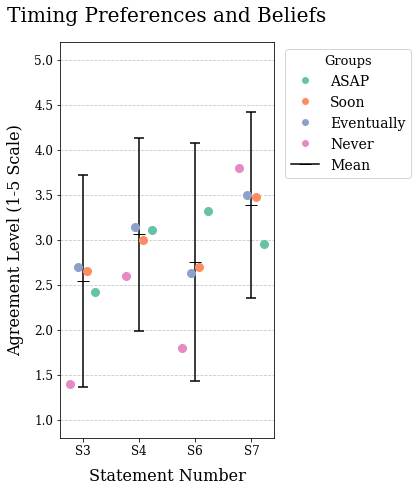

In [66]:
plot_agreement_levels(technical_questions, figure_size=(6,7), pre_means=pre_means, pre_group_means=pre_group_means, post_group_means=post_group_means, title='Timing Preferences and Beliefs', save_pdf=True, blue_bar=False)

In [70]:
def save_legend_separately(groups, colors, blue_bar=False, figure_size=(3, 2), save_path='figs/legend.pdf'):
    """
    Create and save a standalone legend figure.
    
    Parameters:
    groups (list): List of group names
    colors (list): List of colors corresponding to groups
    blue_bar (bool): Whether to include the mean marker in legend
    figure_size (tuple): Size of the legend figure
    save_path (str): Path where to save the legend PDF
    """
    # Create a new figure for just the legend
    fig_legend = plt.figure(figsize=figure_size)
    ax = fig_legend.add_subplot(111)
    
    # Create legend elements
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group, 
                                markerfacecolor=color, markersize=8) 
                      for group, color in zip(groups, colors)]
    
    if not blue_bar:
        legend_elements.append(plt.Line2D([0], [0], marker='_', color='black', 
                                        label='Mean', markersize=12))
    
    # Create legend
    ax.legend(handles=legend_elements, title='Preferred Timelines', fontsize=12, 
             title_fontsize=13, loc='center')
    
    # Turn off axis
    ax.axis('off')
    
    # Save legend with tight layout
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

# Modified main plotting function to optionally skip legend
def plot_agreement_levels(questions_to_include, figure_size=(10, 7), pre_means=None, pre_group_means=None, 
                        post_group_means=None, title=None, use_full_statements=False, 
                        save_pdf=False, blue_bar=True, include_legend=True):
    plt.rcParams.update({'font.size': 12})
    
    fig, ax = plt.subplots(figsize=figure_size)

    x = range(1, len(questions_to_include) + 1)
    bar_width = 0.6

    total_means = pre_means[questions_to_include]
    total_stds = df[questions_to_include].std()

    if blue_bar:
        bars = ax.bar(x, total_means, color='lightblue', alpha=0.7, width=bar_width, 
                     yerr=total_stds, capsize=5, zorder=1)
    else:
        ax.errorbar(x, total_means, yerr=total_stds, fmt='_', color='black', 
                   markersize=12, capsize=5, capthick=1.5, zorder=1)

    groups = ['ASAP', 'Soon', 'Eventually', 'Never']
    colors = sns.color_palette("Set2", n_colors=len(groups))

    num_groups = len(groups)
    offsets = np.linspace(bar_width/2 - bar_width/(num_groups*2),
                         -bar_width/2 + bar_width/(num_groups*2),
                         num_groups)

    for i, group in enumerate(groups):
        pre_group_means_row = pre_group_means.loc[group, questions_to_include]
        group_stds = df[df['Q1'] == group][questions_to_include].std()
        
        for j in range(len(questions_to_include)):
            x_pos = x[j] + offsets[i]
            ax.errorbar(x_pos, pre_group_means_row[j], yerr=group_stds[j], 
                       fmt='o', color=colors[i], capsize=5, capthick=1.5,
                       markersize=8, zorder=2)

    ax.set_ylabel('Agreement Level (1-5 Scale)', fontsize=14, labelpad=10)
    ax.set_xlabel('Statement Number', fontsize=14, labelpad=10)
    if title:
        ax.set_title(title, fontsize=16, pad=20)
    ax.set_xticks(x)
    if use_full_statements:
        ax.set_xticklabels([statements[i] for i in questions_to_include], rotation=45, ha='right')
    else:
        ax.set_xticklabels([f'S{i[-1]}' for i in questions_to_include])

    # Only add legend if include_legend is True
    if include_legend:
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group, 
                                    markerfacecolor=color, markersize=8) 
                          for group, color in zip(groups, colors)]
        
        if not blue_bar:
            legend_elements.append(plt.Line2D([0], [0], marker='_', color='black', 
                                            label='Mean', markersize=12))
        
        ax.legend(handles=legend_elements, title='Groups', fontsize=12, 
                 title_fontsize=13, bbox_to_anchor=(1.02, 1), loc='upper left')

    ax.set_ylim(0.8, 5.2)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    
    if save_pdf:
        plt.savefig(f'figs/{title}.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    # Save legend separately if requested
    if save_pdf:
        save_legend_separately(groups, colors, blue_bar, save_path=f'figs/{title}_legend.pdf')

In [71]:
# make the plot without legend
# plot_agreement_levels(technical_questions, figure_size=(6,7), pre_means=pre_means, pre_group_means=pre_group_means, post_group_means=post_group_means, title='Timing Preferences and Beliefs', save_pdf=True, blue_bar=False, include_legend=False)

# make JUST the legend
groups = ['ASAP', 'Soon', 'Eventually', 'Never']
colors = sns.color_palette("Set2", n_colors=len(groups))
save_legend_separately(groups, colors, blue_bar=False, save_path='figs/legend.pdf')

# OLD


c:\Users\sevde\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


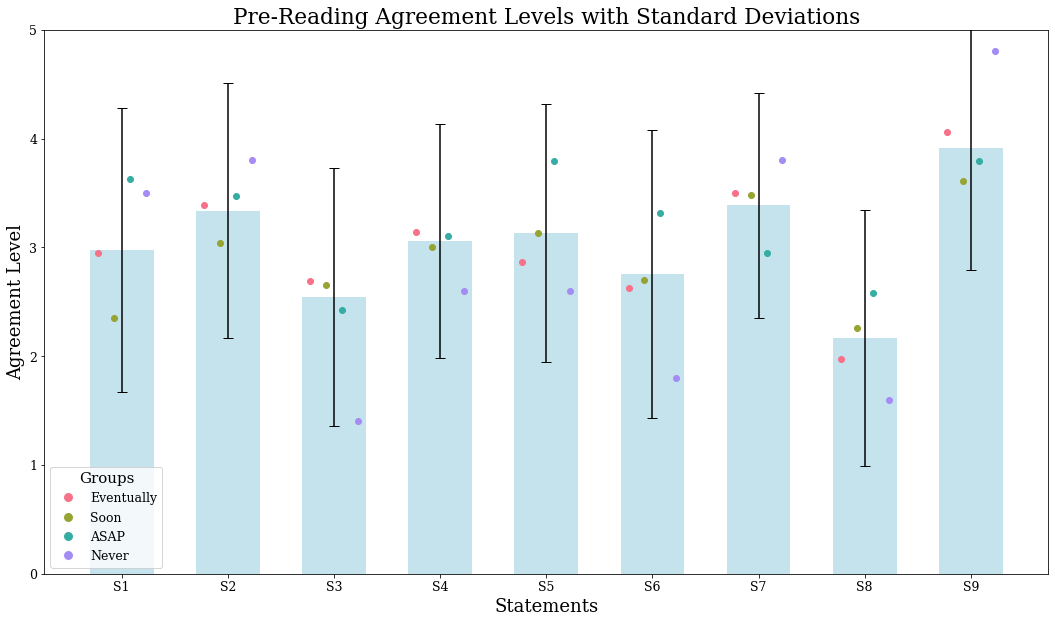

In [26]:
plot_agreement_levels(pre_questions, pre_means=pre_means, pre_group_means=pre_group_means, post_group_means=post_group_means, title='Pre-Reading Agreement Levels with Standard Deviations')

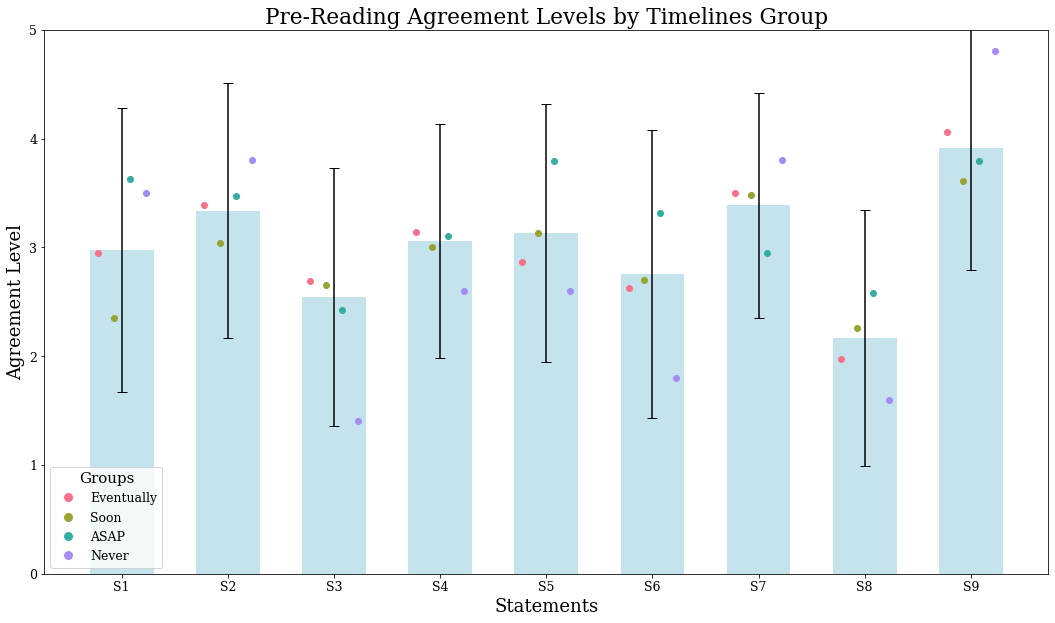

In [27]:
plot_agreement_levels(pre_questions, pre_means=pre_means, pre_group_means=pre_group_means, post_group_means=post_group_means, title='Pre-Reading Agreement Levels by Timelines Group')

In [28]:
priority = [1, 5, 9]
technical = [3,4,6,7]
other = [2,8]

priority_questions = [f'Q6_{i}' for i in priority]
technical_questions = [f'Q6_{i}' for i in technical]
other_questions = [f'Q6_{i}' for i in other]


In [20]:
priority_questions

['Q6_1', 'Q6_5', 'Q6_9']

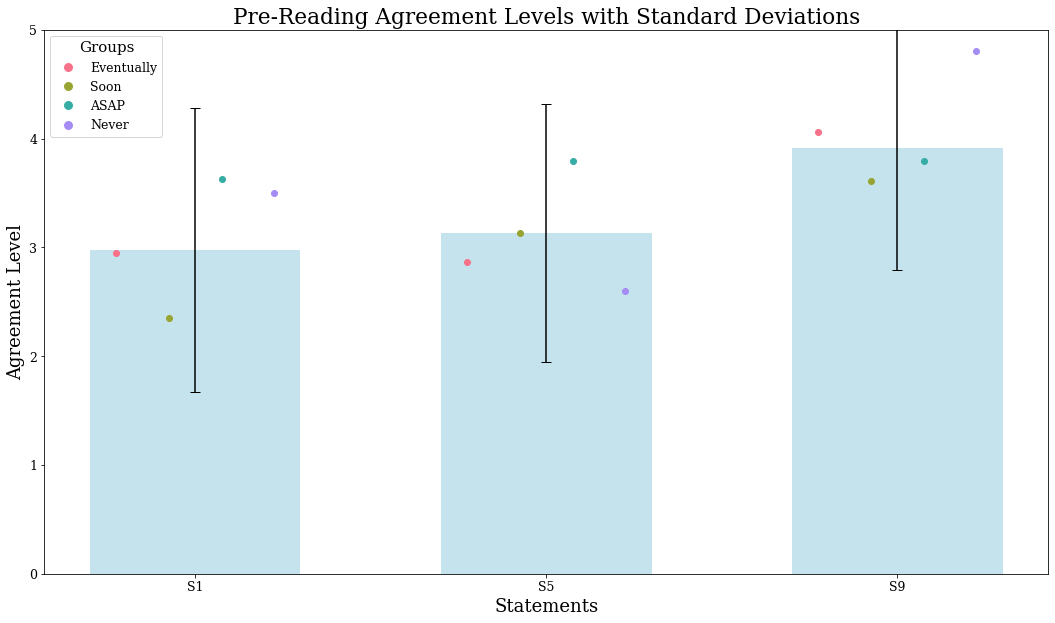

In [21]:
plot_agreement_levels(priority_questions, pre_means=pre_means, pre_group_means=pre_group_means, post_group_means=post_group_means, title='Pre-Reading Agreement Levels with Standard Deviations')

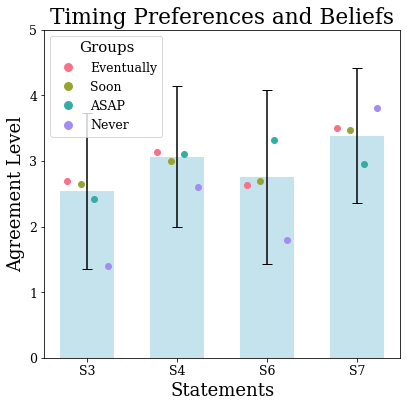

In [22]:
plot_agreement_levels(technical_questions, figure_size=(6,6), pre_means=pre_means, pre_group_means=pre_group_means, post_group_means=post_group_means, title='Timing Preferences and Beliefs', save_pdf=False)

In [23]:
pre_group_means

,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9
Q5,,,,,,,,,
ASAP,3.631579,3.473684,2.421053,3.105263,3.789474,3.315789,2.947368,2.578947,3.789474
Eventually,2.944444,3.388889,2.694444,3.138889,2.861111,2.628571,3.500000,1.972222,4.055556
Never,3.500000,3.800000,1.400000,2.600000,2.600000,1.800000,3.800000,1.600000,4.800000
Soon,2.347826,3.043478,2.652174,3.000000,3.130435,2.695652,3.478261,2.260870,3.608696
